In [1]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
import geopandas as gpd
import folium
import branca.colormap as cm
import libpysal
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point

from libpysal.weights import Queen, Rook, KNN
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
import seaborn as sns
plt.rcParams["font.family"] = "serif"

import matplotlib

font = {
    # 'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 16
}

matplotlib.rc('font', **font)

In [2]:
ROOT = Path.cwd().parent.parent
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
OUT = ROOT / 'out'
ANALYSIS = ROOT / 'data' / 'analysis'

In [3]:
f = "multiple_testing_coeff2.csv"
df = pd.read_csv(OUT / f, index_col=0)
df.variable = df.variable.str.replace("relevel(factor(cluster_name_km_2), ref = ref)", "")
df = df.reset_index(drop=True)

df.head()

,variable,mean,sd,0.025quant,0.5quant,0.975quant,ref,model
0,(Intercept),-6.457829,0.036913,-6.530212,-6.457829,-6.385446,Urban 1,re_poisson
1,Rural 1,0.582803,0.042052,0.500342,0.582803,0.665263,Urban 1,re_poisson
2,Rural 2,0.720457,0.045122,0.631978,0.720457,0.808936,Urban 1,re_poisson
3,Rural 3,0.805438,0.051351,0.704743,0.805438,0.906132,Urban 1,re_poisson
4,Rural 4,0.706045,0.079929,0.549313,0.706045,0.862777,Urban 1,re_poisson


In [4]:
def add_stat_significance(row):
    if row['mean'] > 0 and row['0.025quant'] >0:
        return True
    elif row['mean'] < 0 and row['0.975quant'] <0:
        return True
    else:
        return False
    
df['significant'] = df.apply(add_stat_significance, axis=1)
df.head()

,variable,mean,sd,0.025quant,0.5quant,0.975quant,ref,model,significant
0,(Intercept),-6.457829,0.036913,-6.530212,-6.457829,-6.385446,Urban 1,re_poisson,True
1,Rural 1,0.582803,0.042052,0.500342,0.582803,0.665263,Urban 1,re_poisson,True
2,Rural 2,0.720457,0.045122,0.631978,0.720457,0.808936,Urban 1,re_poisson,True
3,Rural 3,0.805438,0.051351,0.704743,0.805438,0.906132,Urban 1,re_poisson,True
4,Rural 4,0.706045,0.079929,0.549313,0.706045,0.862777,Urban 1,re_poisson,True


In [5]:
models = df['model'].unique()
references = df['ref'].unique()
df = df[df.variable != 'area']
data = []
for ref in references:
    df2 = df[(df['ref'] == ref) & (df.model == 'bym2_poisson')]
    
    d = df2[['variable', 'mean', 'significant']].to_dict(orient='records')
    d = [dict(d2, ref=ref) for d2 in d]
    data.extend(d)

df_coeff = pd.DataFrame.from_dict(data)
df_coeff = df_coeff[df_coeff.variable!='(Intercept)']
# df_coeff.to_csv(OUT / 'multiple_testing_coeff_significance.csv')

# df_coeff.loc[~df_coeff.significant, 'mean'] = np.nan

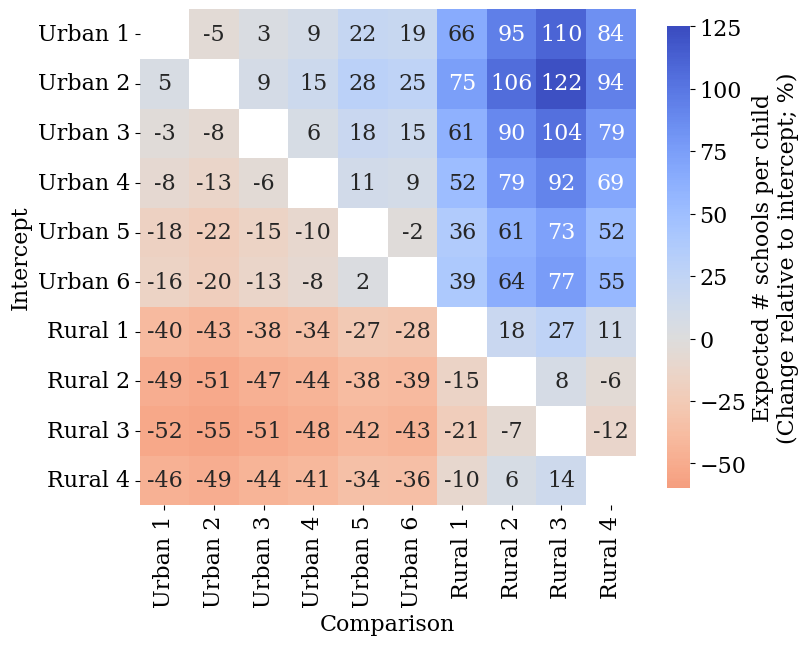

In [6]:
# Number format: 
# https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format 
df_cross = (np.exp(df_coeff.pivot(index='variable', columns='ref', values='mean')).T - 1)*100
df_cross.columns.name = "Comparison"
df_cross.index.name = "Intercept"
col_order = ['Urban 1', 'Urban 2', 'Urban 3', 'Urban 4', 'Urban 5', 'Urban 6', 'Rural 1', 'Rural 2', 'Rural 3', 'Rural 4']
df_cross = df_cross[col_order]
df_cross = df_cross.reindex(col_order) 
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df_cross, cmap='coolwarm_r', center=0, vmin=-60, vmax=125, annot=True, fmt=".0f",
            cbar_kws={'label': 'Expected # schools per child\n(Change relative to intercept; %)', 'shrink':0.75}, ax=ax,square=True,
            # annot_kws={"size": 7}, 
            # legend_kws={}
        )
# ax.figure.axes[-1].yaxis.label.set_size(12)
# ax.figure.axes[-1]
# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
# f.savefig(OUT / 'multiple_testing_coeff_significance_heatmap.png', dpi=300, bbox_inches='tight')

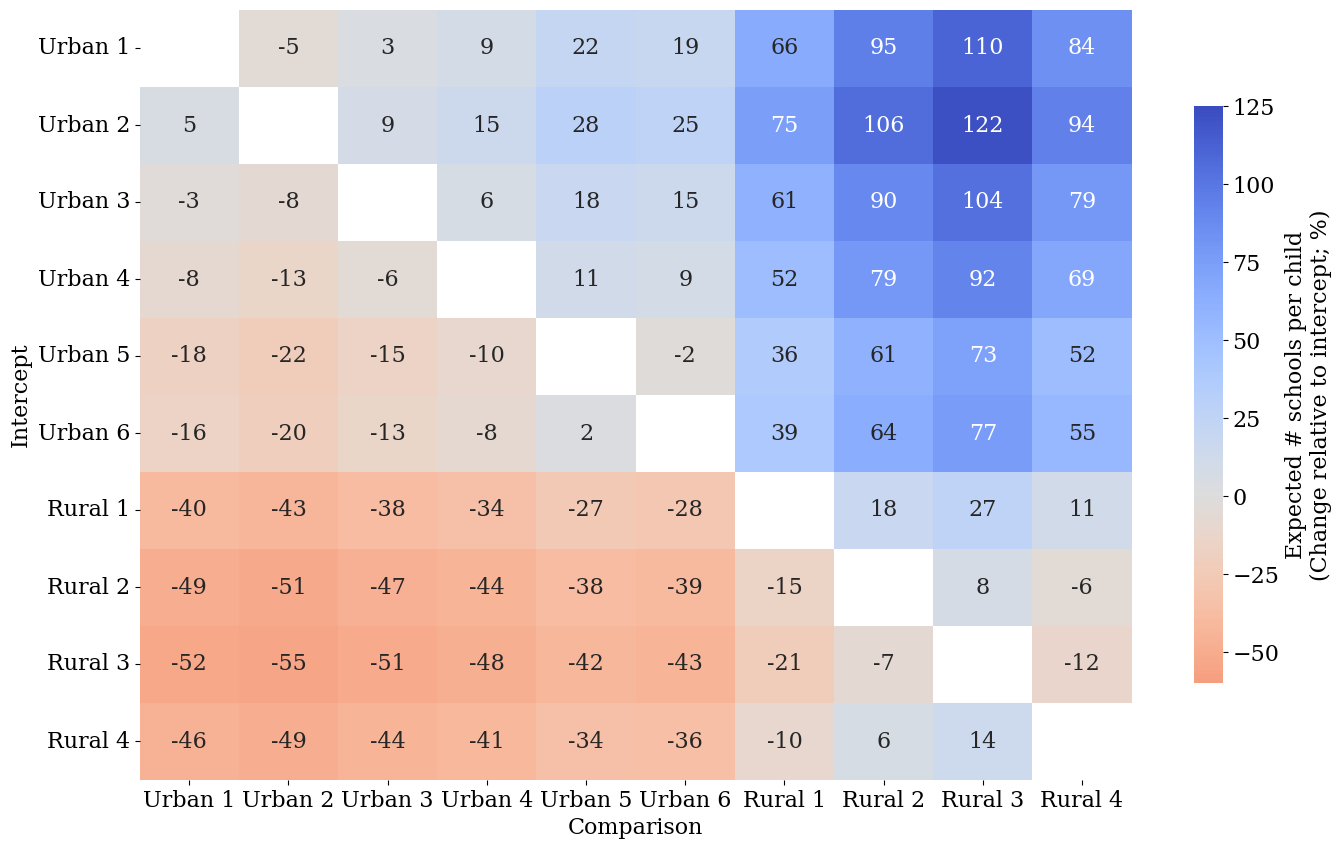

In [8]:
# Number format: 
# https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format 
df_cross = (np.exp(df_coeff.pivot(index='variable', columns='ref', values='mean')).T - 1)*100
df_cross.columns.name = "Comparison"
df_cross.index.name = "Intercept"
col_order = ['Urban 1', 'Urban 2', 'Urban 3', 'Urban 4', 'Urban 5', 'Urban 6', 'Rural 1', 'Rural 2', 'Rural 3', 'Rural 4']
df_cross = df_cross[col_order]
df_cross = df_cross.reindex(col_order) 
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_cross, cmap='coolwarm_r', center=0, vmin=-60, vmax=125, annot=True, fmt=".0f",
            cbar_kws={'label': 'Expected # schools per child\n(Change relative to intercept; %)', 'shrink':0.75}, ax=ax,
            # annot_kws={"size": 7}, 
            # legend_kws={}
        )
# ax.figure.axes[-1].yaxis.label.set_size(12)
# ax.figure.axes[-1]
# f.ax_heatmap.set_xticklabels(f.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
f.savefig(OUT / 'multiple_testing_coeff_significance_heatmap2.png', dpi=300, bbox_inches='tight')